# Classify chest x-rays as w/ or w/o abnormalities

In [1]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/Colab\ Notebooks/kaggle
    from setup_colab import setup_colab_for_kaggle, INPUT_FOLDER, OUTPUT_FOLDER, WORK_FOLDER, dump_dataset_metadata
    setup_colab_for_kaggle(check_env=False, local_working=True)
except:
    print("Not in Colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/kaggle
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Content of Drive Kaggle data dir (/content/drive/MyDrive/kaggle): ['/content/drive/MyDrive/kaggle/input', '/content/drive/MyDrive/kaggle/working', '/content/drive/MyDrive/kaggle/.ipynb_checkpoints', '/content/drive/MyDrive/kaggle/output']
Content of Kaggle data dir (/kaggle): ['/kaggle/output', '/kaggle/input', '/kaggle/working']
Content of Kaggle data subdir (/kaggle/input): ['/kaggle/input/cassava-model', '/kaggle/input/cassava-leaf-disease-classification', '/kaggle/input/googlebitemperedloss', '/kaggle/input/vbdyolo', '/kaggle/input/.ipynb_checkpoints', '/kaggle/input/vinbigdata', '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection', '/kaggle/input/vinbigdata-chest-xray-origi

True

In [2]:
!pip install tensorflow_addons

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras.applications import EfficientNetB3 as EfficientNetBX
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm.notebook import tqdm

INPUT_FOLDER_DATA = INPUT_FOLDER / "vinbigdata-chest-xray-abnormalities-detection"
OUTPUT_FOLDER_CUR = OUTPUT_FOLDER / "vbdbinary"
INPUT_FOLDER_PNG = WORK_FOLDER / "vinbigdata"

2.4.1


Reset the GPU (free any used up memory)

In [4]:
from numba import cuda
cuda.get_current_device().reset()

In [5]:
!nvidia-smi

Sat Mar 13 17:26:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    33W / 250W |      2MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
gpu = tf.config.list_physical_devices("GPU")[0]
tf.config.experimental.set_memory_growth(gpu, False)

## Prepare data for binary classification

In [7]:
%cd {WORK_FOLDER}
!kaggle datasets download xhlulu/vinbigdata -p {INPUT_FOLDER_PNG} --unzip

/kaggle/working
 99% 1.93G/1.94G [00:11<00:00, 199MB/s]
100% 1.94G/1.94G [00:11<00:00, 187MB/s]


In [8]:
train_df = pd.read_csv(INPUT_FOLDER_DATA / "train.csv")
train_df = train_df[["image_id", "class_name"]].groupby("image_id").agg(lambda x: "normal" if (x.to_numpy() == "No finding").all() else "abnormal").reset_index()
train_df["image_file_name"] = train_df["image_id"].astype(str) + ".png"
display(train_df.sample(5))
print(train_df.shape)
display(train_df["class_name"].value_counts())

,image_id,class_name,image_file_name
11217,bddf4fb6f1b93e7401ce177ddfe7ff8e,normal,bddf4fb6f1b93e7401ce177ddfe7ff8e.png
7855,8607d78a67d9e9e4f4d11d1edaacf3e8,normal,8607d78a67d9e9e4f4d11d1edaacf3e8.png
6577,7079fb8735ede4e6209dd4a108f9349d,normal,7079fb8735ede4e6209dd4a108f9349d.png
9616,a3942b8f01dd54858add21b966d3986e,abnormal,a3942b8f01dd54858add21b966d3986e.png
10266,addf6c497e75fe3fe155536ce2b749c8,normal,addf6c497e75fe3fe155536ce2b749c8.png


(15000, 3)


normal      10606
abnormal     4394
Name: class_name, dtype: int64

## Setup image loading and augmentation

In [9]:
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 8

In [10]:
generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.1,
    data_format="channels_last"
)

# Use color_mode=rgb to have the images converted from grayscale.
train_dataset = generator.flow_from_dataframe(
    train_df,
    directory=INPUT_FOLDER_PNG / "train",
    x_col="image_file_name",
    y_col="class_name",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    subset="training"
)

valid_dataset = generator.flow_from_dataframe(
    train_df,
    directory=INPUT_FOLDER_PNG / "train",
    x_col="image_file_name",
    y_col="class_name",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=False
)

Found 13500 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.


Which class is in fact a "positive"

In [11]:
train_dataset.class_indices

{'abnormal': 0, 'normal': 1}

## Configure the model

In [12]:
input = Input(IMAGE_SIZE + (3,))

backbone = EfficientNetBX(include_top=False, weights="imagenet", input_tensor=input, pooling="avg")

backbone.trainable = False
# Unfreeze only some of layers.
for layer in backbone.layers:
    # BatchNormalization should be always kept frozen.
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model = Sequential([
    backbone,
    Dropout(0.2),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 11,573,040
Trainable params: 788,481
Non-trainable params: 10,784,559
______________________________________

In [13]:
optimizer = Adam(learning_rate=1e-3)
loss = BinaryCrossentropy(label_smoothing=0.01)
metrics = [
    BinaryAccuracy(name="accuracy"),
    Precision(name="prec"),
    Recall(name="rec"),
    AUC(name="pr_auc", curve="PR")
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Train the model

In [18]:
OUTPUT_FOLDER_CUR.mkdir(parents=True, exist_ok=True)

model_checkpoint = ModelCheckpoint(OUTPUT_FOLDER_CUR / "chest_xray_binary_best.h5", monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=3, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1)
tqdm_callback = tfa.callbacks.TQDMProgressBar()

results = model.fit(
    train_dataset,
    epochs=30,
    # steps_per_epoch=10,
    shuffle=False, # Already shuffled by datagen
    callbacks=[model_checkpoint, early_stopping, reduce_lr_on_plateau, tqdm_callback],
    validation_data=valid_dataset,
    # validation_steps=10,
    verbose=0
)

model.save(OUTPUT_FOLDER_CUR / "chest_xray_binary.h5")

Epoch 1/30



Epoch 2/30



Epoch 3/30



Epoch 4/30



Epoch 5/30



Epoch 6/30



Epoch 7/30



Epoch 8/30



Epoch 9/30



Epoch 10/30



Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 11/30



Epoch 12/30



Epoch 13/30



Epoch 14/30



Epoch 15/30



Epoch 16/30



Epoch 17/30



Epoch 18/30



Epoch 19/30



Epoch 20/30



Epoch 00020: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 21/30


Restoring model weights from the end of the best epoch.

Epoch 00021: early stopping



## Learning curves and model performance

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(14, 7))

sns.lineplot(x=results.epoch, y=results.history["loss"], ax=ax[0], label="Training loss")
sns.lineplot(x=results.epoch, y=results.history["val_loss"], ax=ax[0], label="Validation loss")
ax[0].set_title("Loss")

sns.lineplot(x=results.epoch, y=results.history["accuracy"], ax=ax[1], label="Training accuracy")
sns.lineplot(x=results.epoch, y=results.history["val_accuracy"], ax=ax[1], label="Validation accuracy")
_ = ax[1].set_title("Accuracy")

## Evaluate
Get predictions for validation set and print classification report

In [14]:
model.load_weights(OUTPUT_FOLDER_CUR / "chest_xray_binary_best.h5")

In [15]:
[val_loss, val_accuracy, val_prec, val_rec, val_pr_auc] = model.evaluate(valid_dataset, callbacks=[tfa.callbacks.TQDMProgressBar()], verbose=0)

In [16]:
valid_pred_probabilities = model.predict(
    valid_dataset,
    callbacks=[tfa.callbacks.TQDMProgressBar()]
)
valid_predictions = valid_pred_probabilities.round().reshape(-1).astype(np.int32)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(valid_dataset.classes, valid_predictions, target_names=list(train_dataset.class_indices.keys()), ))

              precision    recall  f1-score   support

    abnormal       0.85      0.81      0.83       443
      normal       0.92      0.94      0.93      1057

    accuracy                           0.90      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.90      0.90      0.90      1500



Text(0.5, 1.0, 'Precision-Recall Curve')

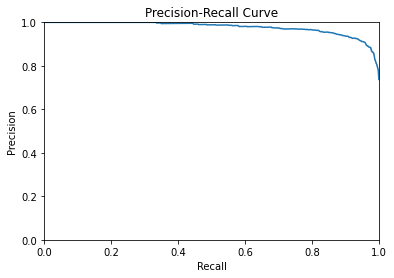

In [20]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(valid_dataset.classes, valid_pred_probabilities)

ax = sns.lineplot(x=recall, y=precision)
ax.set(xlabel="Recall", ylabel="Precision")
ax.axis([0, 1, 0, 1])
ax.set_title("Precision-Recall Curve")

## Predict

In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class_id_to_name = {v: k for k, v in train_dataset.class_indices.items()}
images = list((INPUT_FOLDER_PNG / "test").iterdir())
results = pd.DataFrame(columns=["image_id", "class_name"])

for image_file in tqdm(images, total=len(images)):
    image = load_img(image_file, target_size=IMAGE_SIZE)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    pred_prob = model.predict(image)
    pred = int(pred_prob.round().squeeze())

    results = results.append({"image_id": image_file.stem, "class_name": class_id_to_name[pred]}, ignore_index=True)

results.to_csv(OUTPUT_FOLDER_CUR / "prediction.csv", index=False)
results.sample(5)

,image_id,class_name
1221,780f385ed80d16130dad48d823b1ee0f,normal
2050,56cb181941ae9b45448469cc0e420ba7,normal
2024,8d53f1f5d327b1e1642bdb63d697c4fe,abnormal
1755,00b7e6bfa4dc1fe9ddd0ce74743e38c2,abnormal
1350,b698b97d189f5660ba5ffa52c142ac50,normal


## Store output to Kaggle

In [21]:
dump_dataset_metadata("witalia", "vbdbinary", OUTPUT_FOLDER_CUR)

version_notes = "" #@param
# !kaggle datasets create -p {OUTPUT_FOLDER_CUR} -r zip
!kaggle datasets version -m {version_notes} -p {OUTPUT_FOLDER_CUR} -r zip

Starting upload for file prediction.csv
100% 119k/119k [00:00<00:00, 565kB/s]
Upload successful: prediction.csv (119KB)
Starting upload for file chest_xray_binary_best.h5
100% 50.8M/50.8M [00:00<00:00, 74.4MB/s]
Upload successful: chest_xray_binary_best.h5 (51MB)
Starting upload for file chest_xray_binary.h5
100% 50.8M/50.8M [00:00<00:00, 74.4MB/s]
Upload successful: chest_xray_binary.h5 (51MB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/witalia/vbdbinary
